In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load datasets
customers = pd.read_csv("/content/drive/MyDrive/Classroom/Customers.csv")
transactions = pd.read_csv("/content/drive/MyDrive/Classroom/Transactions.csv")

In [3]:
# Merge datasets
merged_data = transactions.merge(customers, on="CustomerID")

 Feature Engineering

In [4]:
# Aggregate transaction data
customer_features = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total spending
    "Quantity": "sum",   # Total quantity purchased
}).reset_index()

In [5]:
# Merge with customer profile data
customer_features = customer_features.merge(customers, on="CustomerID")

In [6]:
# One-hot encoding for 'Region'
encoder = OneHotEncoder()
encoded_region = encoder.fit_transform(customer_features[["Region"]]).toarray()
encoded_region_df = pd.DataFrame(encoded_region, columns=encoder.get_feature_names_out(["Region"]))

In [7]:
# Normalize numerical features
scaler = StandardScaler()
numerical_features = customer_features[["TotalValue", "Quantity"]]
normalized_numerical = scaler.fit_transform(numerical_features)
normalized_df = pd.DataFrame(normalized_numerical, columns=["TotalValue_scaled", "Quantity_scaled"])

In [8]:
# Combine all features
final_features = pd.concat([encoded_region_df, normalized_df], axis=1)


 Clustering

In [9]:
# Try different numbers of clusters (2 to 10)
results = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(final_features)
    db_index = davies_bouldin_score(final_features, clusters)
    results[k] = {"model": kmeans, "clusters": clusters, "db_index": db_index}

In [10]:
# Select the best number of clusters based on DB Index
best_k = min(results, key=lambda x: results[x]["db_index"])
best_model = results[best_k]["model"]
best_clusters = results[best_k]["clusters"]
best_db_index = results[best_k]["db_index"]

In [11]:
# Add cluster labels to the original customer data
customer_features["Cluster"] = best_clusters


In [12]:
# Dimensionality Reduction for Visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(final_features)

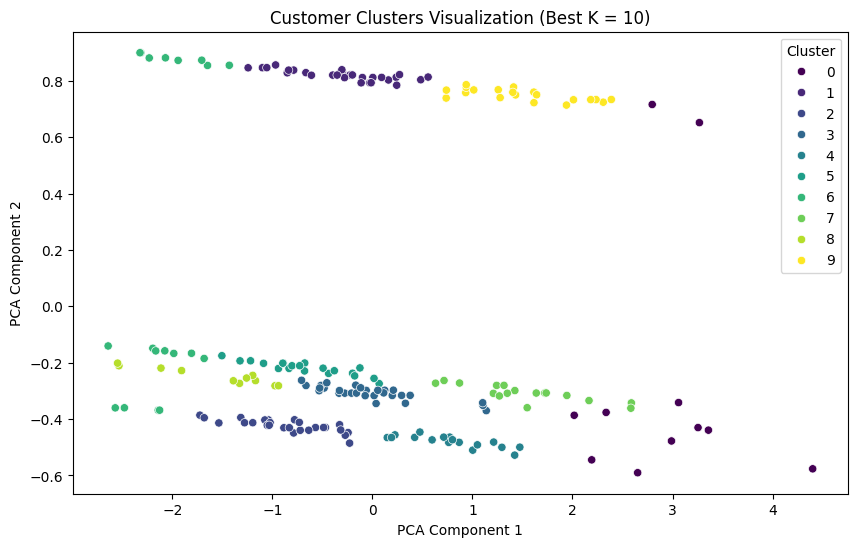

In [13]:
# Plot Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    hue=customer_features["Cluster"],
    palette="viridis",
    legend="full"
)
plt.title(f"Customer Clusters Visualization (Best K = {best_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


In [14]:
# Save clustering results
customer_features[["CustomerID", "Cluster"]].to_csv("Vechalapu_Tejaswini_Clusters.csv", index=False)


In [15]:
# Output Clustering Metrics
print(f"Best Number of Clusters (K): {best_k}")
print(f"Davies-Bouldin Index for Best Model: {best_db_index:.4f}")

Best Number of Clusters (K): 10
Davies-Bouldin Index for Best Model: 0.9131
